# LOAD DATASET

In [1]:
!wget https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt

--2018-12-30 15:11:50--  https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155418 (152K) [text/plain]
Saving to: ‘20k.txt’

20k.txt             100%[===================>] 151,78K   804KB/s    in 0,2s    

2018-12-30 15:11:51 (804 KB/s) - ‘20k.txt’ saved [155418/155418]



In [3]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec

--2018-12-31 04:31:37--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.45
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6,1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec.1’

wiki.en.vec.1       100%[===================>]   6,14G  5,61MB/s    in 14m 42s 

2018-12-31 04:46:21 (7,13 MB/s) - ‘wiki.en.vec.1’ saved [6597238061/6597238061]



# PREPARE DATASET

In [1]:
# UTILS #
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
#from yellowbrick.cluster import SilhouetteVisualizer

# TEXT LIBS #
import gensim

# ML LIBS #
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
google_words = []
with open('20k.txt', 'r') as f:
    google_words = [w[:-1] for w in f]

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('wiki.en.vec.1', binary=False)

fasttext с mipt-telecom качалась неприлично долго, поэтому я использовала google colab, на котором ограничена память. Что бы уложиться пришлось качать только .vec без ngram и выкинуть из выборки некоторые слова. Благо их не много...

In [6]:
X = []
for w in google_words:
    try:
        X.append(model[w])
    except KeyError:
        print('Unknown word ' + w)
X = np.array(X)
np.savetxt("drive/My Drive/model.csv", X, delimiter=",")

Unknown word sexcam
Unknown word milfhunter
Unknown word postposted
Unknown word starsmerchant
Unknown word ampland
Unknown word thumbzilla
Unknown word livesex
Unknown word worldsex
Unknown word msgstr
Unknown word sublimedirectory
Unknown word viewpicture
Unknown word acdbentity
Unknown word zshops
Unknown word listprice
Unknown word knowledgestorm
Unknown word vsnet
Unknown word feof
Unknown word bufing
Unknown word voyuer
Unknown word beastality
Unknown word tittens
Unknown word storesshop
Unknown word blogthis
Unknown word libdevel
Unknown word spermshack
Unknown word xlibs
Unknown word milfseeker
Unknown word pricetool
Unknown word acdbline
Unknown word trustpass
Unknown word debuginfo
Unknown word telefonsex
Unknown word madthumbs
Unknown word kudoz
Unknown word phonephone
Unknown word zoofilia
Unknown word zerodegrees
Unknown word secsg
Unknown word condosaver
Unknown word classicvacations
Unknown word tiava
Unknown word insest
Unknown word searchsearch
Unknown word ripencc
Unk

В дальнейшем будем пользоваться сохраненными векторами, что бы не хдать каждый раз когда загрузится модель

In [4]:
X = np.genfromtxt("model.csv", delimiter=',')

# DATASET ANALYSIS

Посмотрим на гистограммы слов по признакам. Особо ничего интересного сказать нельзя. Получилось нормальное распределение вокруг 0, как и предполагалось в FastText. Выбросы отсутствуют.

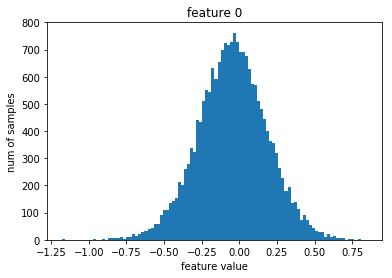

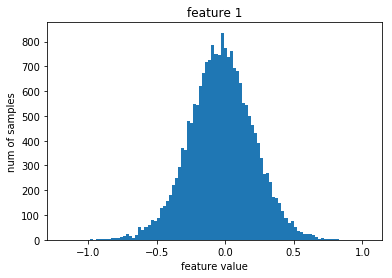

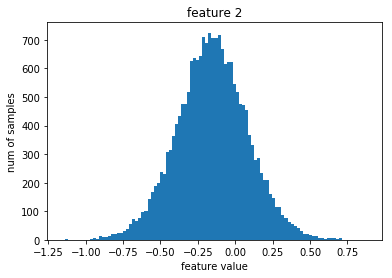

In [5]:
for i in range(3):
    plt.hist(X[:, i], bins=100)
    plt.title("feature {}".format(i))
    plt.xlabel("feature value")
    plt.ylabel("num of samples")
    plt.show()

# MODEL

Будем использовать K-means и попробуем искать наилучшее количество кластеров по различным метрикам: евклидово расстояние и косинусная мера (внутрикластерное расстояние и межкластерное расстояние). Итого 4 метрики. За расстояние между кластерами принято расстояние между центрами кластеров, что немного лукавство, ну да ладно... Нам хотелось бы минимизировать внутрикластерное расстояние и косинусную похожесть между кластерами, а максимизировать межкластерное евклидово расстояние и внутрикластерную косинусную схожесть. В идеале нам хотелось бы что бы (межкластерное расстояние - внутрикластерное) / max(внутрикластерное, межкластерное) -> 1. Приложены графики:

In [47]:
def int_metr(X, Y, n_clusters):
    clust = [[] for _ in range(n_clusters)]
    for i in range(len(X)):
        clust[Y[i]].append(X[i])
    
    eu_avg = 0
    cos_average = []
    for i in range(n_clusters):
        cs = cosine_similarity(clust[i])
        cs_avg = 0
        for k in range(len(cs)):
            for j in range(k+1, len(cs)):
                cs_avg += cs[k][j]
        if len(clust[i]) == 1:
            cos_average.append(cs[0][0])
        else:
            cos_average.append(cs_avg / (((len(clust[i])**2) - len(clust[i])) / 2))
        max_row = 0
        cs = euclidean_distances(clust[i])
        for k in range(len(cs) // 2):
            max_row = max(max_row, max(cs[k]))
        eu_avg += max_row
    
    return np.array(cos_average).mean(), eu_avg / n_clusters

def ext_metr(centers):
    cosine = cosine_similarity(centers)
    cs = []
    for i in range(len(cosine)):
        for j in range(i+1, len(cosine)):
            cs.append(cosine[i][j])
    cosine = np.array(cs).mean()
    distances = euclidean_distances(centers)
    cs = []
    for i in range(len(distances)):
        for j in range(i+1, len(distances)):
            cs.append(distances[i][j])
    dist = np.array(cs).mean()
    return cosine, dist

In [49]:
range_n_clusters = np.arange(1000, 4000, 200)
'''
ic = []
ie = []
ec = []
ee = []
'''
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    avg_internal_cosine, avg_internal_eucl = int_metr(X, cluster_labels, n_clusters)
    avg_external_cosine, avg_external_eucl = ext_metr(clusterer.cluster_centers_)
    ic.append(avg_internal_cosine)
    ie.append(avg_internal_eucl)
    ec.append(avg_external_cosine)
    ee.append(avg_external_eucl)

    print("For n_clusters =", n_clusters,
        "\naverage between clusters cosine similarity is", avg_external_cosine, 
        "\naverage between clusters euclidean distance is", avg_external_eucl,
        "\naverage among clusters cosine similarity is", avg_internal_cosine, 
        "\naverage among clusters euclidean distance is", avg_internal_eucl)

For n_clusters = 1000 
average between clusters cosine similarity is 0.28508220882638224 
average between clusters euclidean distance is 4.43051855378622 
average among clusters cosine similarity is 0.5220442426059242 
average among clusters euclidean distance is 5.716753060475638
For n_clusters = 1200 
average between clusters cosine similarity is 0.27376919765463764 
average between clusters euclidean distance is 4.582534779463035 
average among clusters cosine similarity is 0.5429387840096667 
average among clusters euclidean distance is 5.5076374023608
For n_clusters = 1400 
average between clusters cosine similarity is 0.2592292657407178 
average between clusters euclidean distance is 4.807426887297778 
average among clusters cosine similarity is 0.5681579826334481 
average among clusters euclidean distance is 5.239628506558609
For n_clusters = 1600 
average between clusters cosine similarity is 0.2530602724078216 
average between clusters euclidean distance is 4.853522267647604 


Посмотрим на графики. Косинусная схожесть увеличивается с возрастанием количества кластеров. Значит, что векторы в одном кластере в среднем становятся сонаправлеными и более кучно расположенными т.к. евклидово расстояние уменьшается. В то же время евклидово расстояние между кластерами увеличивается и косинусная похожесть между кластерами уменьшается. Последний график показывает зависимость метрики silhoutte от количества кластеров. Нам хочется что бы это значение приближалось к 1.

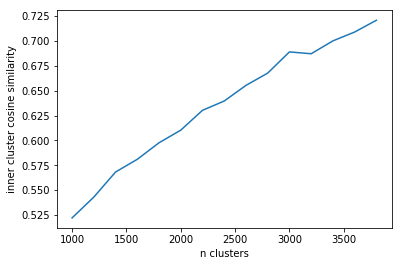

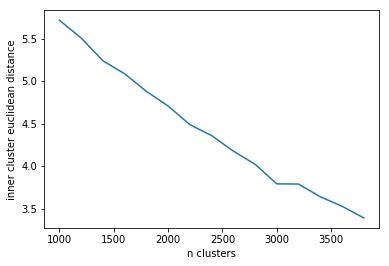

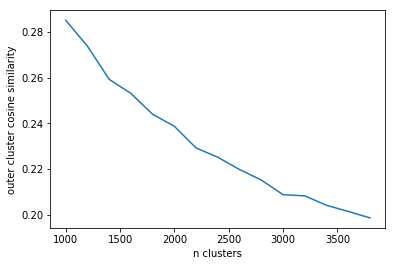

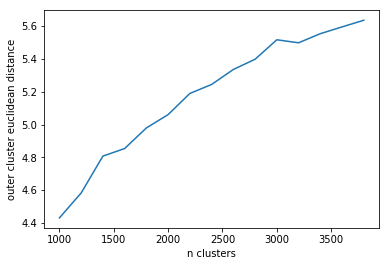

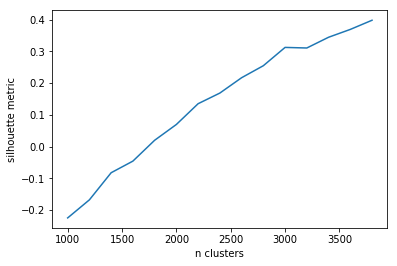

In [50]:
range_n_clusters = np.arange(1000, 4000, 200)
plt.plot(range_n_clusters, ic)
plt.xlabel("n clusters")
plt.ylabel("inner cluster cosine similarity")
plt.show()
plt.plot(range_n_clusters, ie)
plt.xlabel("n clusters")
plt.ylabel("inner cluster euclidean distance")
plt.show()
plt.plot(range_n_clusters, ec)
plt.xlabel("n clusters")
plt.ylabel("outer cluster cosine similarity")
plt.show()
plt.plot(range_n_clusters, ee)
plt.xlabel("n clusters")
plt.ylabel("outer cluster euclidean distance")
plt.show()
silhouette = []
for i in range(len(ie)):
    silhouette.append((ee[i] - ie[i]) / max(ee[i], ie[i]))
plt.plot(range_n_clusters, silhouette)
plt.xlabel("n clusters")
plt.ylabel("silhouette metric")
plt.show()

Посмотрим наконец, какие слова вошли в один кластер. Видно, что в некоторых класстерах вместе оказались взаимозаменяемые  слова (по крайней мере кажется fasttext задумывался так, что взаимозаменяемое будет лежать рядом): lenght, distance, rush; historical, cultural, historic. Но вообще выглядит, что 4000 кластеров маловато и надо считать дальше, но слишком медленно, на моей машине выходит. Принцип понятен :) С Новым Годом!

In [ ]:
clusterer = KMeans(n_clusters=4000, random_state=10)
Y = clusterer.fit_predict(X)
clust = [[] for _ in range(4000)]
for i in range(len(X)):
    clust[Y[i]].append(google_words[i])

In [59]:
from random import random

for _ in range(10):
    c = int(random() * 4000)
    print(c, clust[c])

2971 ['historical', 'cultural', 'historic', 'adapt']
830 ['peak', 'advent']
3034 ['cisco', 'wrought', 'phenotype']
2917 ['proceeds', 'willis', 'sts', 'carmel', 'listeners', 'nineteenth', 'buster', 'waking', 'approving']
3708 ['ordinary', 'np', 'frost', 'instrumentation', 'sac', 'precedent']
3125 ['entertaining']
1026 ['puerto', 'woods', 'subchapter']
3104 ['rom', 'wasted']
3857 ['auditing', 'sigh']
2802 ['rhetoric']


Эксперимент заключался в разделении заданной выборки слов на кластеры по взаимозаменяемости(в одном кластере взаимозаменяемые слова). В результате, как мы видим, действительно получились кластеры слов, но разделение ещё далеко от совершенства. Для более точного результата необходимо использовать большее количество кластеров, но это заняло бы слишком много времени.